# Classification task of predicting if the client will subscribe a term deposit

## Imports

In [2]:
import opendatasets as od
import numpy as np
import pandas as pd
import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:,.2f}'.format)

%load_ext autoreload
%autoreload all

from utils import (outlier_range,
                   bi_cat_countplot, bi_cat_countplot_no_outliers,
                   bi_cat_countplot_sort_index,
                   bi_numeric_kde, bi_numeric_kde_no_outliers)

## Load the data

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv/'
temp_dir = './temp'
data_dir = './data'

od.download(dataset_url, temp_dir)

for root, dirs, files in os.walk(temp_dir):
    if files:
        dataset_path = root

for file in os.listdir(dataset_path):
    src = os.path.join(dataset_path, file)
    dst = os.path.join(data_dir, file)
    shutil.move(src, dst)

shutil.rmtree(temp_dir)

print("Dataset moved successfully to:", data_dir)

Dataset URL: https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv


100%|██████████| 391k/391k [00:00<00:00, 909kB/s]



Dataset moved successfully to: ./data


In [4]:
os.listdir(data_dir)

['bank-additional-full.csv', 'bank_data.csv']

In [5]:
data = pd.read_csv('./data/bank-additional-full.csv', sep=';')

## EDA

### Initial Data Overview

In [6]:
print(f'Dataset consist of {data.shape[0]} rows and {data.shape[1]} columns.')

Dataset consist of 41188 rows and 21 columns.


In [7]:
data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
31448,36,management,single,university.degree,no,yes,yes,cellular,may,wed,147,2,999,1,failure,-1.80,92.89,-46.20,1.33,"5,099.10",no
26160,38,technician,married,professional.course,no,yes,yes,cellular,nov,wed,11,3,999,0,nonexistent,-0.10,93.20,-42.00,4.12,"5,195.80",no
12093,45,technician,single,professional.course,unknown,yes,no,telephone,jun,fri,293,3,999,0,nonexistent,1.40,94.47,-41.80,4.95,"5,228.10",no
16858,43,blue-collar,married,basic.9y,unknown,no,no,cellular,jul,thu,401,1,999,0,nonexistent,1.40,93.92,-42.70,4.96,"5,228.10",no
25279,29,technician,married,professional.course,no,yes,no,cellular,nov,tue,54,2,999,0,nonexistent,-0.10,93.20,-42.00,4.15,"5,195.80",no


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Dataset has 10 numerical and 11 categorical columns.

### Missing Values

In [9]:
data.isnull().values.any()

False

There are no missing values.

### Target variable distribution

In [10]:
target_col = 'y'

In [11]:
print("Percentage of each class:")
data[target_col].value_counts(normalize=True) * 100

Percentage of each class:


y
no    88.73
yes   11.27
Name: proportion, dtype: float64

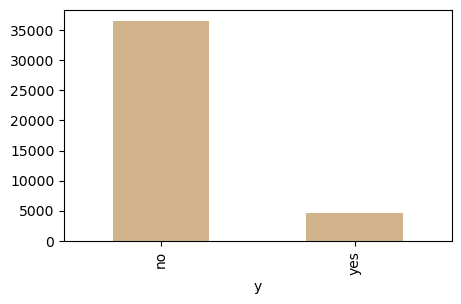

In [12]:
plt.figure(figsize=(5, 3))
data[target_col].value_counts().plot(kind='bar', color='tan')
plt.show()

### Numerical Features

In [13]:
numeric_cols = data.select_dtypes('number').columns.to_list()
print("Numerical features:", numeric_cols)

Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [14]:
data[numeric_cols].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,"41,188.00","41,188.00","41,188.00","41,188.00","41,188.00","41,188.00","41,188.00","41,188.00","41,188.00","41,188.00"
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,"5,167.04"
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,"4,963.60"
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,"5,099.10"
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,"5,191.00"
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,"5,228.10"
max,98.00,"4,918.00",56.00,999.00,7.00,1.40,94.77,-26.90,5.04,"5,228.10"


It's look like all numerical data are correct.

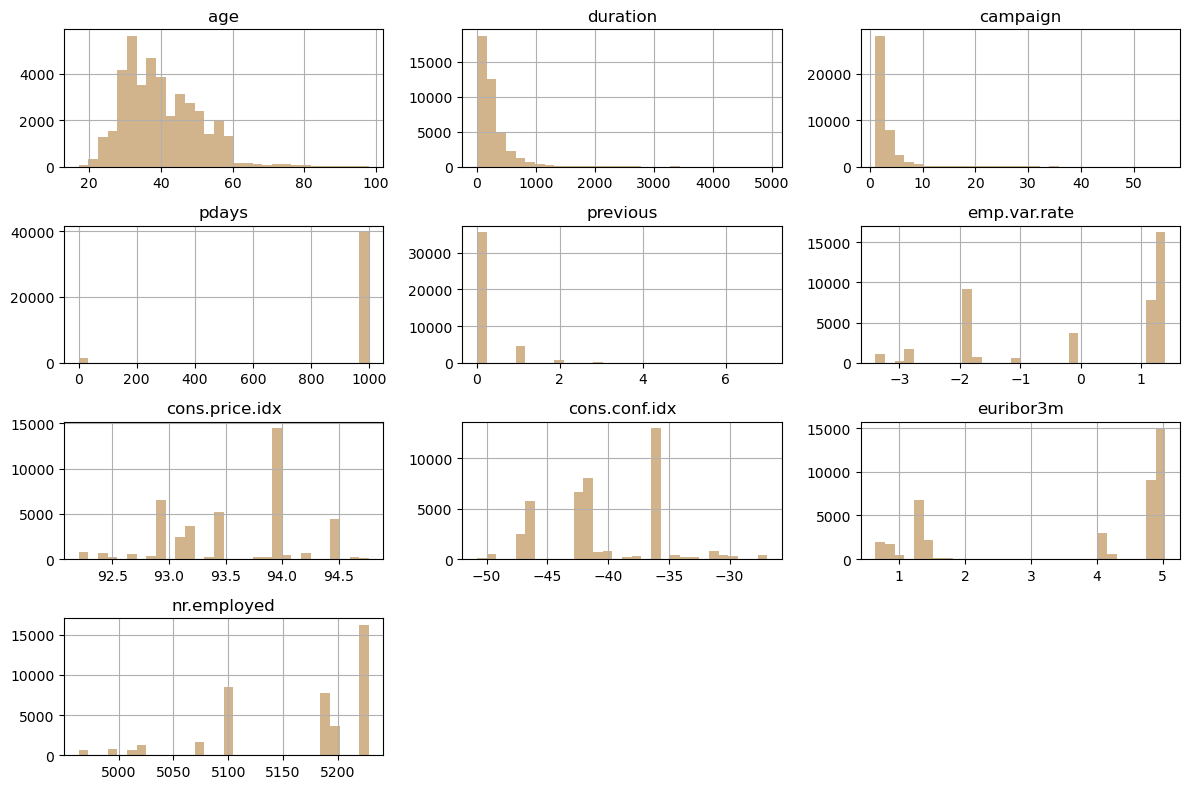

In [15]:
data[numeric_cols].hist(bins=30, figsize=(12, 8), layout=(4, 3), color='tan')
plt.tight_layout()
plt.show()

- Consider transformations (log or scaling) for skewed variables such as `duration` and `campaign`
- Investigate potential outliers in `age`, `duration` and `pdays` to determine whether they should be removed or treated differently.
- Analyze the correlation between economic indicators and the target variable (y) to assess their predictive power.
- Evaluate whether `pdays` and `previous` should be treated as categorical variables instead of numerical ones.

#### `age`

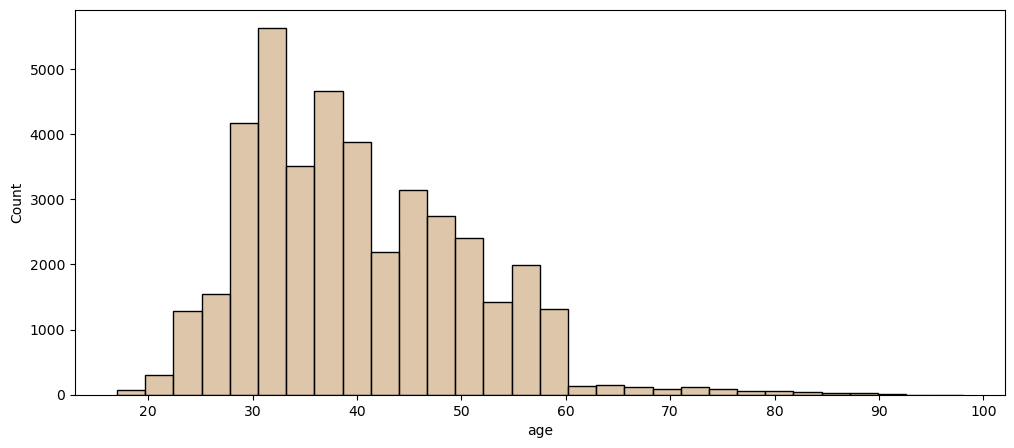

In [16]:
plt.figure(figsize=(12, 5))
sns.histplot(x=data['age'], color='tan', bins=30)
plt.show()

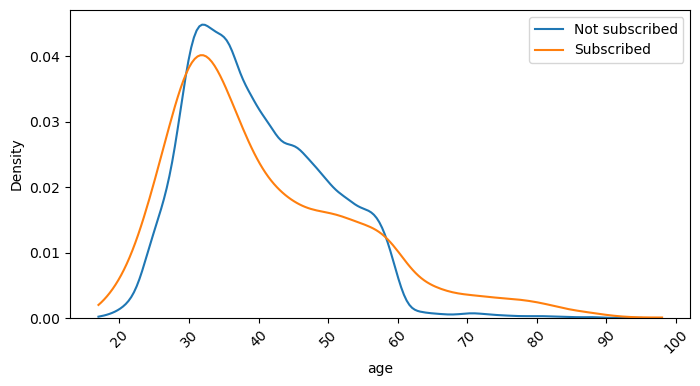

In [17]:
bi_numeric_kde(data, 'age')

- The distribution is right-skewed.
- Clients younger than 30 and older than 59 were more likely to subscribe to a term deposit.

#### `campaign`

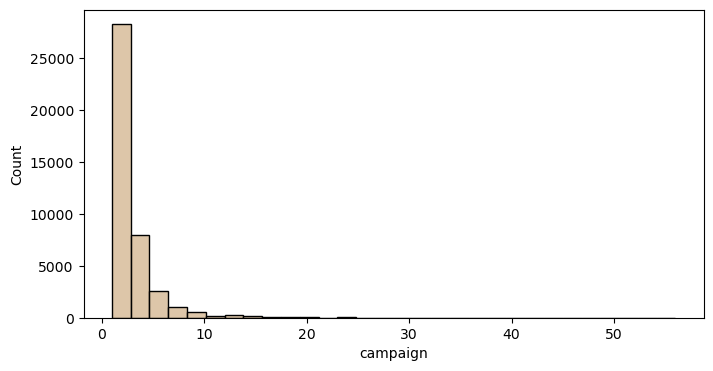

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(x=data['campaign'], color='tan', bins=30)
plt.show()

In [19]:
(data['campaign'].value_counts(normalize=True) * 100)[:15]

campaign
1    42.83
2    25.66
3    12.97
4     6.44
5     3.88
6     2.38
7     1.53
8     0.97
9     0.69
10    0.55
11    0.43
12    0.30
13    0.22
14    0.17
17    0.14
Name: proportion, dtype: float64

Let's look at the `campaign` column distribution without outliers.

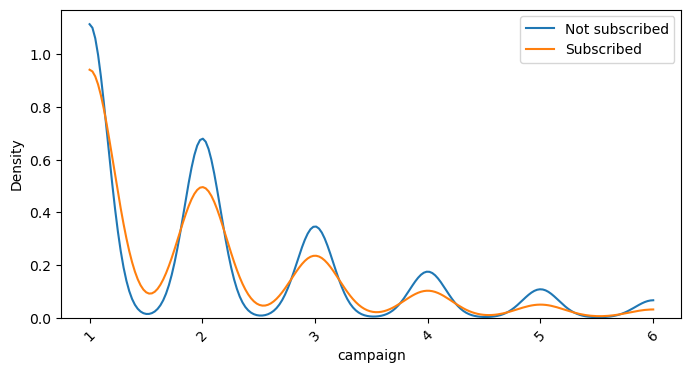

In [20]:
bi_numeric_kde_no_outliers(data, 'campaign')

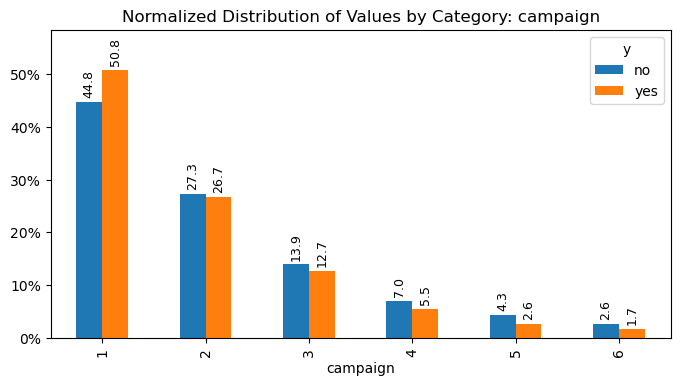

In [21]:
bi_cat_countplot_no_outliers(data, 'campaign', 'y')

- The `campaign` feature has a highly skewed distribution.
- 42.83% of clients had only 1 contact performed during this campaign.
- Clients who had only 1 contact during this campaign were more likely to subscribe to a term deposit (50.8% vs. 44.8%)
- Clients who had more the 1 contact were less likely to subscribe to a term deposit.

#### `pdays`

In [22]:
(data['pdays'].value_counts(normalize=True) * 100)[:15]

pdays
999   96.32
3      1.07
6      1.00
4      0.29
9      0.16
2      0.15
7      0.15
12     0.14
10     0.13
5      0.11
13     0.09
11     0.07
1      0.06
15     0.06
14     0.05
Name: proportion, dtype: float64

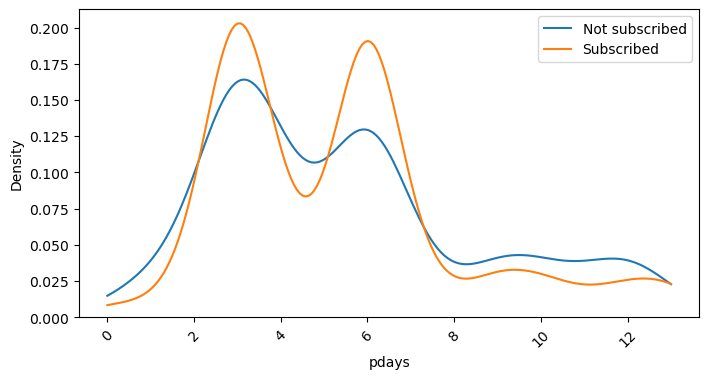

In [23]:
bi_numeric_kde_no_outliers(data[data.pdays != 999], 'pdays')

- 96% of clients were not previously contacted.
- Clients were more likely to subscribe to a term deposit if 3 or 6 days had passed since the last contact from a previous campaign.

#### `previous`


In [24]:
(data['previous'].value_counts(normalize=True) * 100)[:15]

previous
0   86.34
1   11.07
2    1.83
3    0.52
4    0.17
5    0.04
6    0.01
7    0.00
Name: proportion, dtype: float64

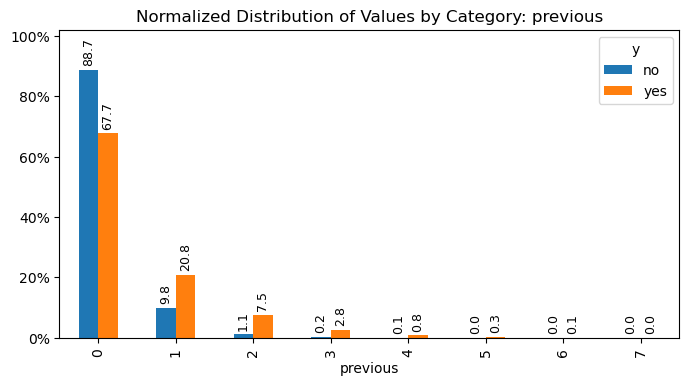

In [25]:
bi_cat_countplot(data, 'previous', 'y')

- The `previous` feature has a highly skewed distribution.
- 86% of clients had no contact before this campaign.
- Clients with prior contacts were more likely to subscribe to a term deposit.
- Clients without prior contacts were less likely to subscribe to a term deposit (88.7% vs. 67.7%).

#### `emp.var.rate`


In [26]:
(data['emp.var.rate'].value_counts(normalize=True) * 100)

emp.var.rate
1.40    39.41
-1.80   22.30
1.10    18.85
-0.10    8.94
-2.90    4.04
-3.40    2.60
-1.70    1.88
-1.10    1.54
-3.00    0.42
-0.20    0.02
Name: proportion, dtype: float64

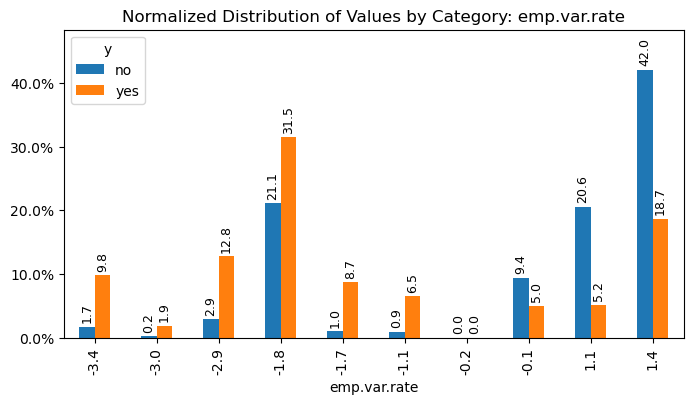

In [27]:
bi_cat_countplot_sort_index(data, 'emp.var.rate', 'y')

- In the quarter when `employment variation rate` < -0.1 clients were likely to subscribe to a term deposit.

#### `cons.price.idx`


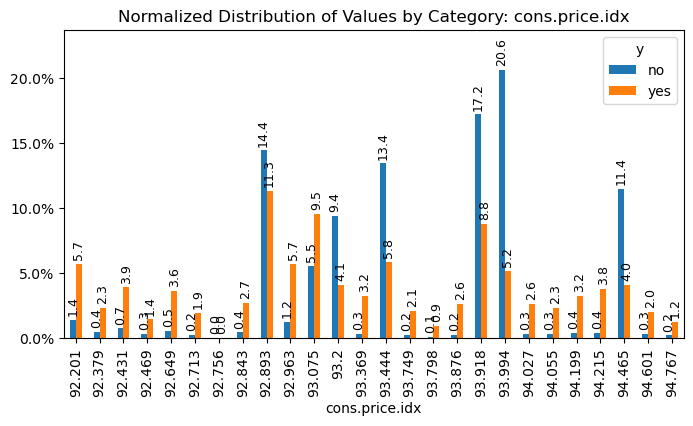

In [28]:
bi_cat_countplot_sort_index(data, 'cons.price.idx', 'y')

- For the `consumer price index`, changes over time are more relevant than absolute values.

Since our dataset is ordered by date from May 2008 to November 2010, we can create an additional column to capture the month-over-month change in `cons.price.idx`, providing more insight into economic trends. 

In [29]:
data['cons.price.idx_diff'] = (data['cons.price.idx']
                               .diff()
                               .replace(0, np.nan)
                               .ffill()
                               .fillna(0)
                               .round(3))

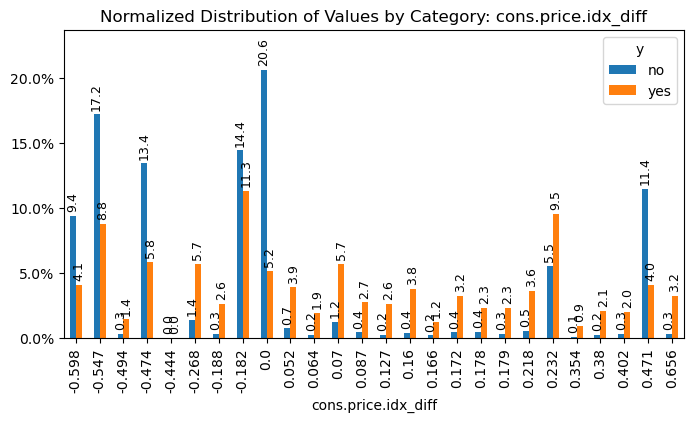

In [30]:
bi_cat_countplot_sort_index(data, 'cons.price.idx_diff', 'y')

- A large share of `y = yes` responses is spread across various changes, while `y = no` responses cluster around 0.00 and negative values.
- This suggests that clients might be more likely to subscribe when the price index fluctuates significantly, possibly indicating a more uncertain economic environment where promotional efforts are more effective.

#### `cons.conf.idx`


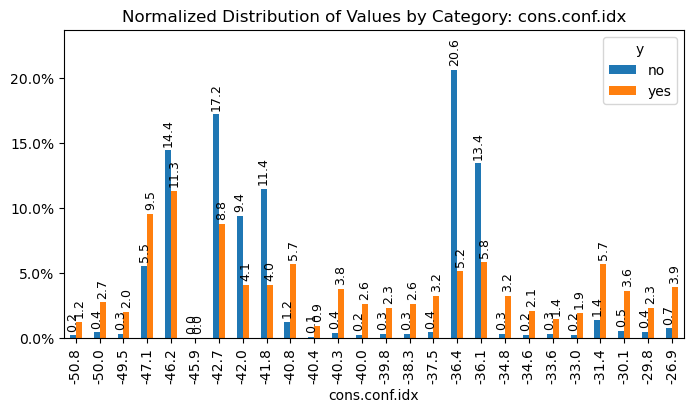

In [31]:
bi_cat_countplot_sort_index(data, 'cons.conf.idx', 'y')

- For the `consumer confidence index`, changes over time are more relevant than absolute values.
- Only at six specific values of `cons.conf.idx` and `cons.price.idx` did clients prefer not to subscribe to a term deposit (these values may have occurred at the same time).

Similar to `cons.price.idx`, we can create an additional column to capture the month-over-month change in `cons.conf.idx`, providing insights into consumer confidence trends over time. 

In [32]:
data['cons.conf.idx_diff'] = (data['cons.conf.idx']
                              .diff()
                              .replace(0, np.nan)
                              .ffill()
                              .fillna(0)
                              .round(3))

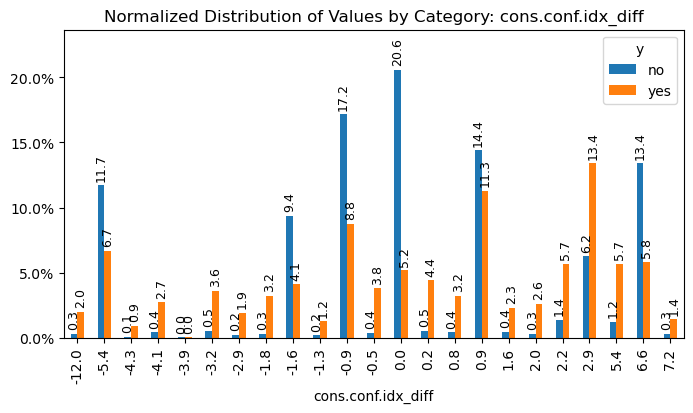

In [33]:
bi_cat_countplot_sort_index(data, 'cons.conf.idx_diff', 'y')

- Similar to `cons.price.idx_diff`, the `cons.conf.idx_diff` values for `y = yes` are more widely distributed, while `y = no` responses are more clustered around fewer values.
- A notable observation is that larger shifts (both positive and negative) in cons.conf.idx_diff appear more frequently in the y = yes group (e.g., -5.40, 6.60, 5.40).
- This suggests that customers might be more likely to respond positively to marketing efforts when consumer confidence is unstable—whether due to economic concerns or optimism.


#### `euribor3m`


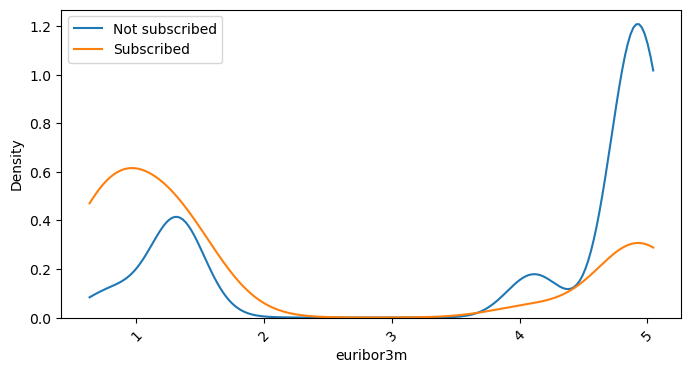

In [34]:
bi_numeric_kde(data, 'euribor3m')

- During the period when `euribor3m` was below 2, clients were more likely to subscribe to a term deposit.

#### `nr.employed`

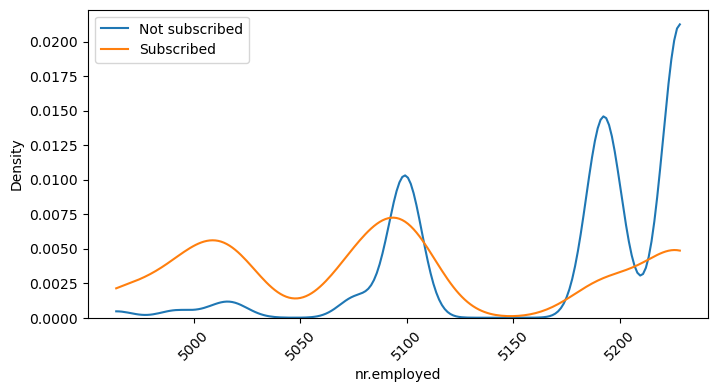

In [35]:
bi_numeric_kde(data, 'nr.employed')

- Clients were more likely to subscribe to a term deposit during periods with a lower number of employees.

### Categorical Features

In [36]:
categorical_cols = data.drop(columns='y').select_dtypes('object').columns.to_list()
print("Categorical features:", categorical_cols)

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [37]:
data[categorical_cols].describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


Unique Categories Distribution

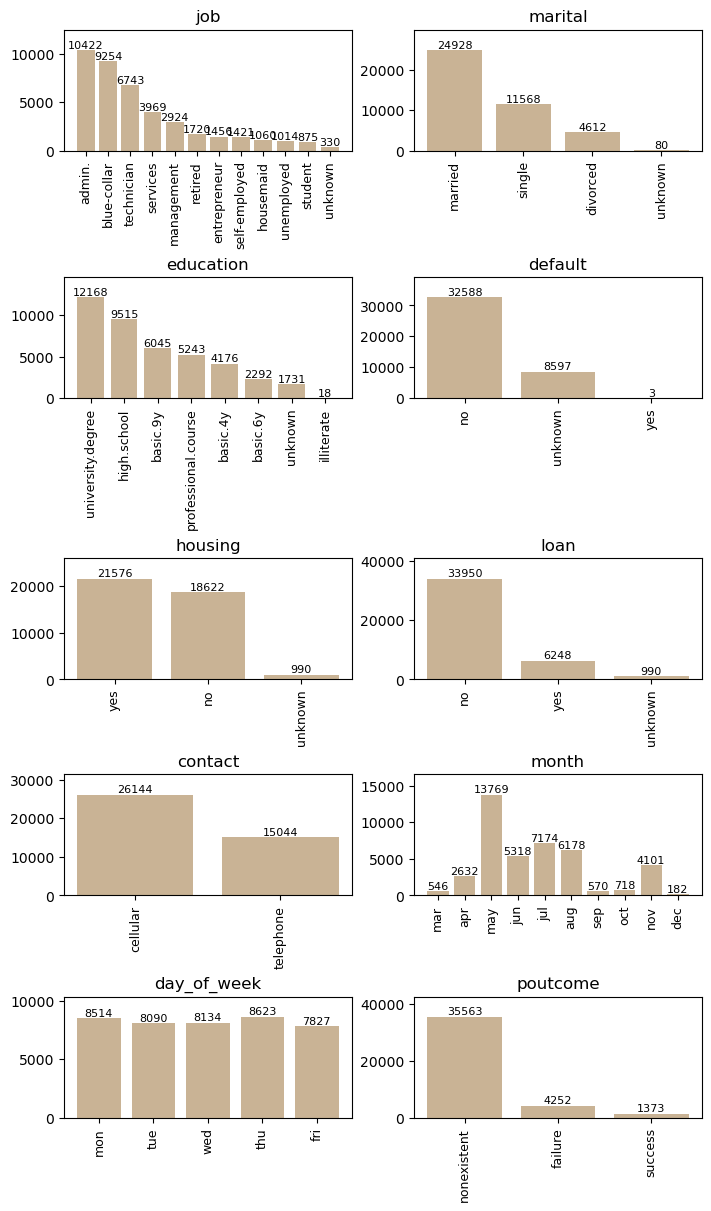

In [38]:
data['month'] = pd.Categorical(
    data['month'],
    ordered=True,
    categories=['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
)

data['day_of_week'] = pd.Categorical(
    data['day_of_week'],
    ordered=True,
    categories=['mon', 'tue', 'wed', 'thu', 'fri']
)

fig, axs = plt.subplots(5, 2, figsize=(7, 12), layout='constrained')
for ax, col in zip(axs.flat, categorical_cols):
    orders = data[col].value_counts().index if col not in ['month', 'day_of_week'] else None
    ax.set_title(col)
    sns.countplot(x=data[col], color='tan', ax=ax, order=orders)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelrotation=90, labelsize=9)
    ax.bar_label(ax.containers[0], fontsize=8)
    ax.margins(x=0.05, y=0.2)

plt.show()

- `job`: The dataset contains multiple job types, with the most frequent being `admin.`, `blue-collar`, and `technican`.
- `marital`: The majority of individuals are `married`, followed by `single` and `divorced`.
- `education`: The dataset includes different education levels, the majority of clients has university degree but there are also few illiterate clients.
- `default`, `housing`, and `loan`: These are binary categorical variables (yes/no) with `unknown` type, which maybe should be detail examined before using them in modeling.
- `contact`: The dataset includes only two communication types (`cellular` and `telephone`). 
- `month` and `day_of_week`: These categorical time-related features could be transformed into numerical representations (e.g., mapping months to numbers).
- `poutcome` (previous campaign outcome): The categories `success`, `failure`, `nonexistent` provide useful historical information, with `nonexistent` being the most common, indicating that many individuals have not been contacted before.

Further actions: consider encoding categorical variables based on their nature (one-hot encoding, ordinal encoding).

#### `job`


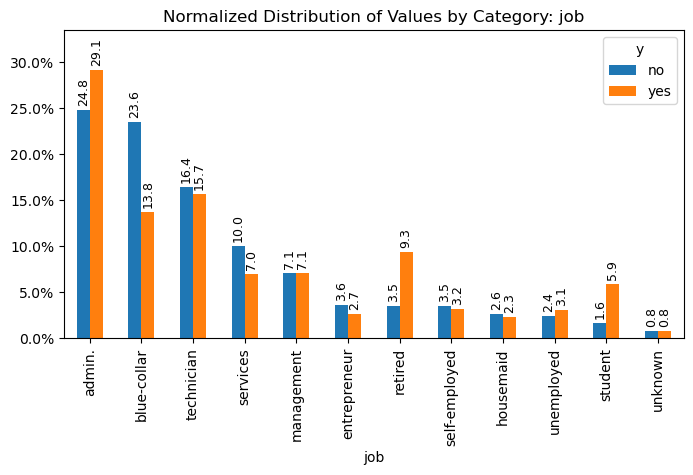

In [39]:
bi_cat_countplot(data, 'job', 'y')

- Clients with job categories like `blue-collar` and `services` were more likely not to subscribe to a term deposit
- Clients with job categories such as `admin.`, `retired`, and `student` were more likely to subscribe to a term deposit.
- We could use One-Hot Encoding for the `job` category feature.

#### `marital`


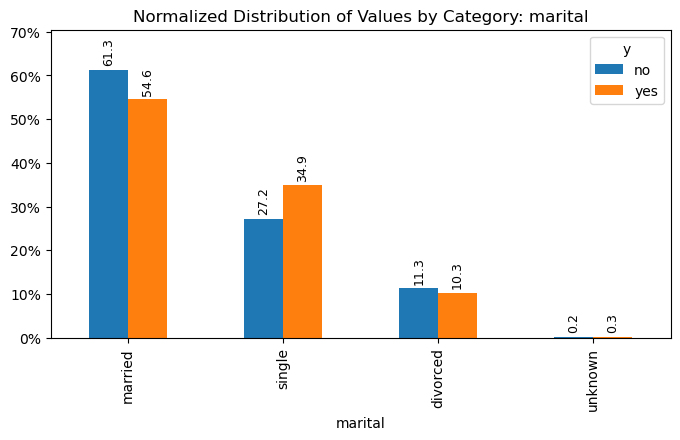

In [40]:
bi_cat_countplot(data, 'marital', 'y')

- `Single` clients more more likely to subscribe to a term deposit (34.9% vs. 27.2%).
- We could use One-Hot Encoding for the `marital` status.

#### `education`


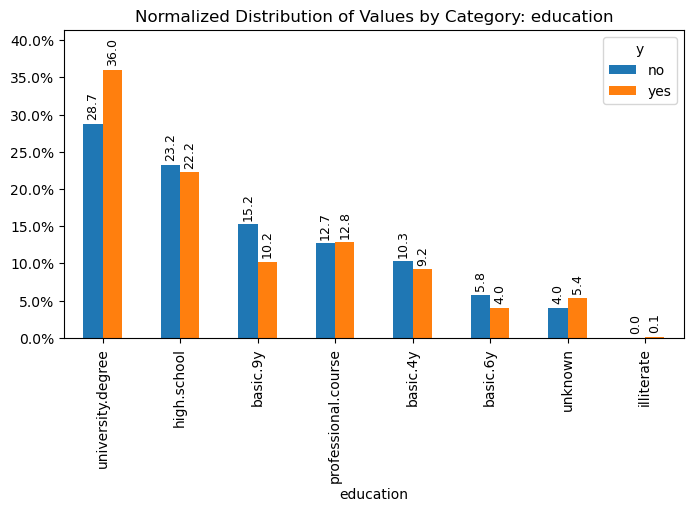

In [41]:
bi_cat_countplot(data, 'education', 'y')

- Clients with `university degree` more likely to subscribe to a term deposit (36% vs. 28.7%).
- Clients with `basic 9 year` education more likely not to subscribe to a term deposit (15.2% vs. 10.2%).
- For the education categories we could use one-hot encoding and ordinal encoding depends on how we interpret the relationship between these categories:
    - Ordinal Encoding could make sense, if we treat education levels as having an inherent order: 'illiterate' < 'basic.4y' < 'basic.6y' < 'basic.9y' < 'high.school' < 'professional.course' < 'university.degree'. 
    - One-hot Encoding would treat each category as distinct and unrelated.

#### `default`

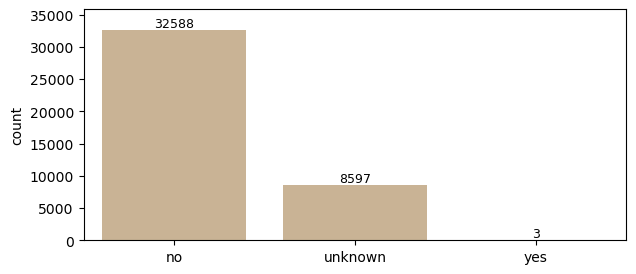

In [42]:
plt.figure(figsize=(7, 3))
ax = sns.countplot(x=data['default'], color='tan')
ax.bar_label(ax.containers[0], fontsize=9)
ax.margins(y=0.1)
plt.xlabel('')
plt.show()

In [43]:
data[data['default'] == 'yes']

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cons.price.idx_diff,cons.conf.idx_diff
21580,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,66,1,999,0,nonexistent,1.40,93.44,-36.10,4.96,"5,228.10",no,-0.47,6.60
21581,48,technician,married,professional.course,yes,yes,no,cellular,aug,tue,133,1,999,0,nonexistent,1.40,93.44,-36.10,4.96,"5,228.10",no,-0.47,6.60
24866,31,unemployed,married,high.school,yes,no,no,cellular,nov,tue,111,2,999,1,failure,-0.10,93.20,-42.00,4.15,"5,195.80",no,-0.60,-1.60


Since the `default` column has only 3 rows with `yes`, it is highly imbalanced and may not contribute much to the analysis or predictive modeling.

**Possible Actions:**
1. Remove the rows with `yes` (if not informative)
2. If 'default' is somewhat relevant, we could stay and apply OneHotEncoder.
3. If this values of `default` feature are important, but we need more instances, oversampling techniques like SMOTE or simple duplication of rare cases could help.

For the analysis and first attempt of modeling we could change it to category `unknown`.

In [44]:
data['default'] = data['default'].apply(lambda x: 'unknown' if x == 'yes' else x)

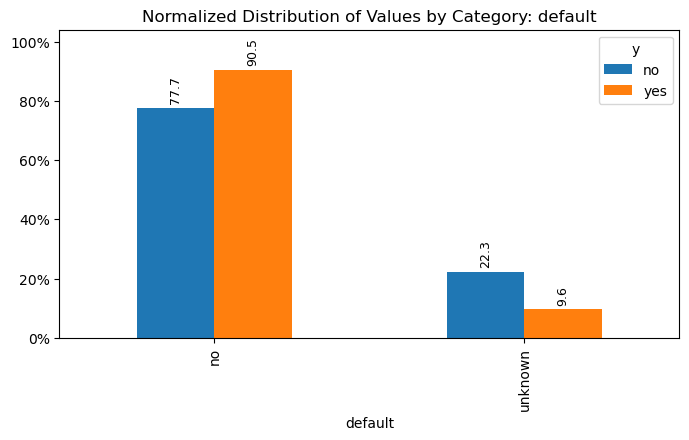

In [45]:
bi_cat_countplot(data, 'default', 'y')

- Clients without credits were more likely to subscribe to a term deposit (90.5% vs. 77.7%).

#### `housing`


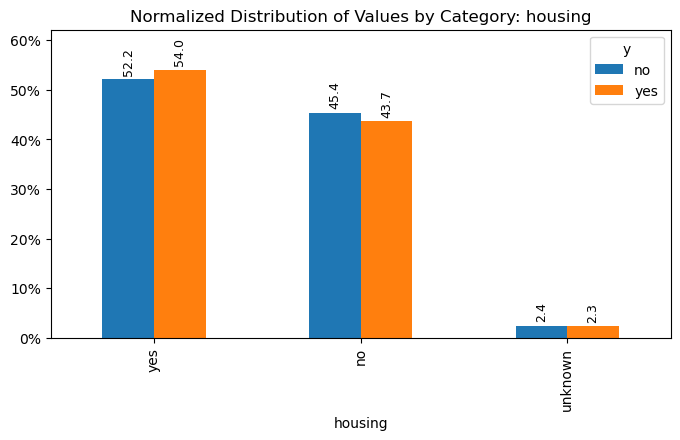

In [46]:
bi_cat_countplot(data, 'housing', 'y')

- There is no significant difference between clients with or without a housing loan.
- We could use One-Hot Encoding for the `housing` feature.

#### `loan`


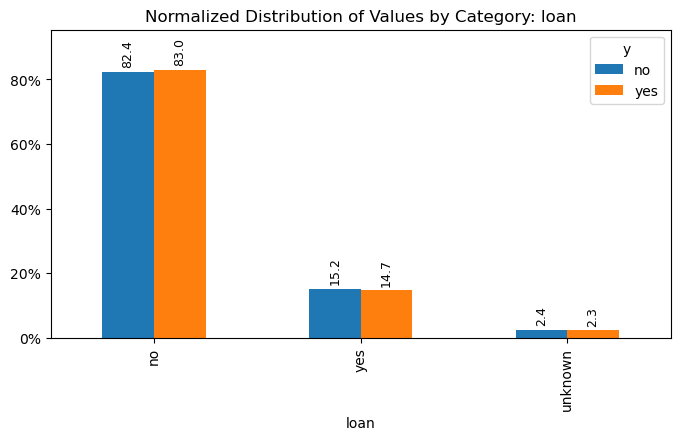

In [47]:
bi_cat_countplot(data, 'loan', 'y')

- There is no significant difference between clients with or without a personal loan.
- We could use One-Hot Encoding for the `loan` feature.

#### `contact`


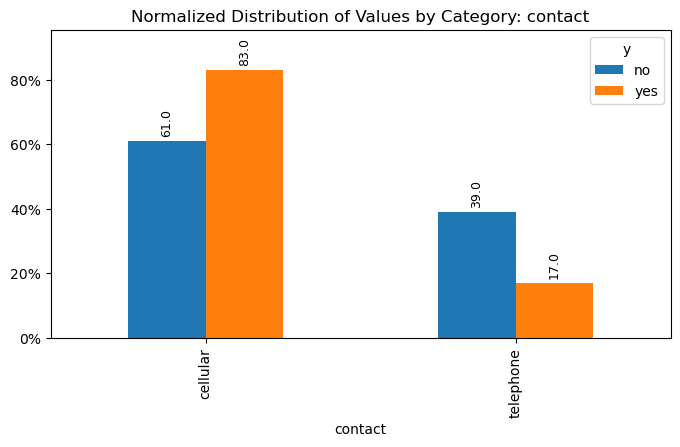

In [48]:
bi_cat_countplot(data, 'contact', 'y')

- Clients with the `cellular` communication type were more likely to subscribe to a term deposit compared to clients with the `telephone` communication type.
- We could use One-Hot Encoding for the `contact` type feature.

#### `poutcome`

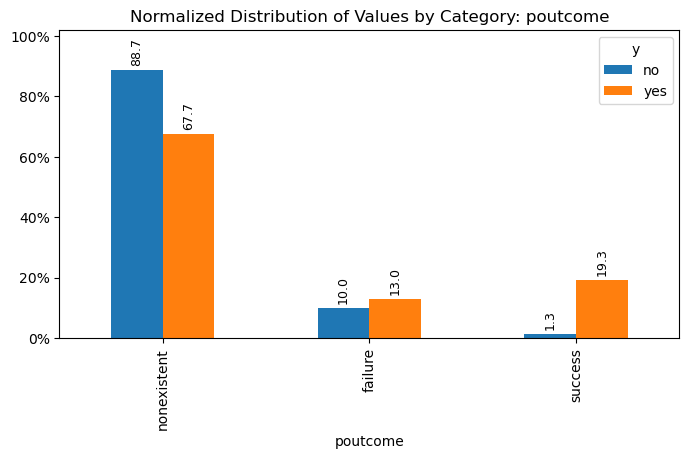

In [49]:
bi_cat_countplot(data, 'poutcome', 'y')

- Clients who did not participate in the previous marketing campaign were less likely to subscribe to a term deposit (88.7% vs. 67.7%).
- Clients with `success` result in the previous marketing campaign were more likely to subscribe to a term deposit (19.3% vs. 1.3%).
- We could use One-Hot Encoding for the `poutcome` feature.

#### `month`

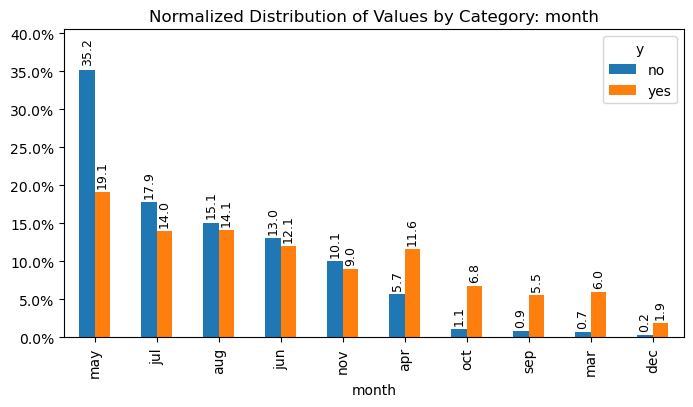

In [50]:
bi_cat_countplot(data, 'month', 'y')

- In May, more clients were less likely to subscribe to a term deposit (35.2% vs. 19.1%).
- In months as April, October, September, March, and December, clients were more likely to subscribe to a term deposit.
- This categorical time-related feature could be transformed into numerical representations, e.g., mapping months to numbers.

#### `day_of_week`

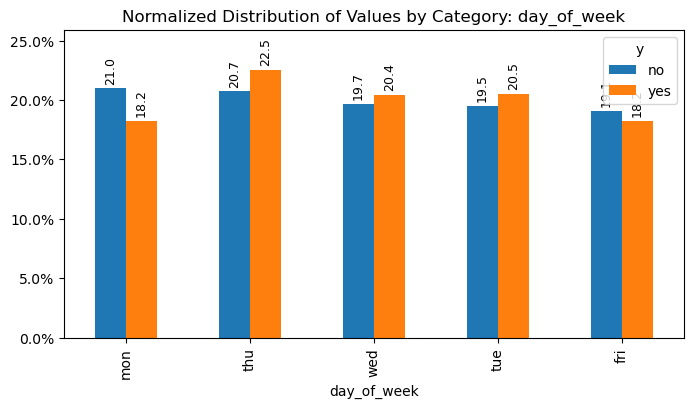

In [51]:
bi_cat_countplot(data, 'day_of_week', 'y')

- There is no significant difference based on the last contact day of the week.
- However, on Monday and Friday, clients slightly less likely to subscribe to a term deposit. 
- This feature could be transformed into numerical representations, e.g., by mapping days to numbers.

### Correlations

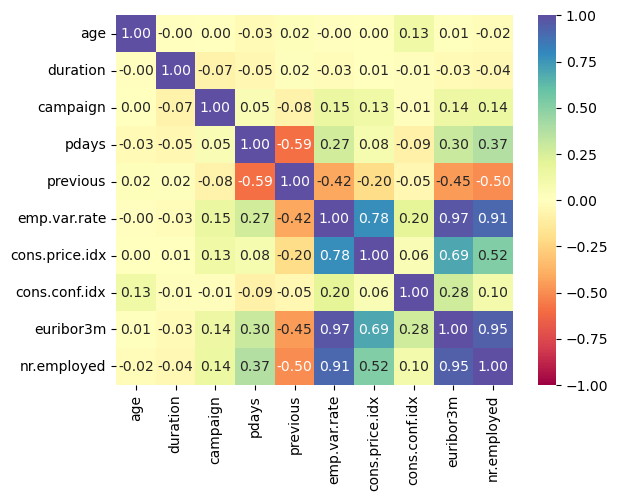

In [52]:
corr_matrix = data[numeric_cols].corr()
sns.heatmap(corr_matrix,
            vmin=-1,
            vmax=1,
            annot=True,
            cmap='Spectral',
            fmt='.2f')
plt.show()

In [53]:
corr_matrix[corr_matrix<1].unstack().sort_values(key=abs, ascending=False).head(20)

euribor3m       emp.var.rate      0.97
emp.var.rate    euribor3m         0.97
nr.employed     euribor3m         0.95
euribor3m       nr.employed       0.95
nr.employed     emp.var.rate      0.91
emp.var.rate    nr.employed       0.91
                cons.price.idx    0.78
cons.price.idx  emp.var.rate      0.78
                euribor3m         0.69
euribor3m       cons.price.idx    0.69
previous        pdays            -0.59
pdays           previous         -0.59
nr.employed     cons.price.idx    0.52
cons.price.idx  nr.employed       0.52
nr.employed     previous         -0.50
previous        nr.employed      -0.50
                euribor3m        -0.45
euribor3m       previous         -0.45
emp.var.rate    previous         -0.42
previous        emp.var.rate     -0.42
dtype: float64

- Strong Multicollinearity:
    - `emp.var.rate` and `euribor3m` (0.97)
    - `nr.employed` and `euribor3m` (0.95)
    - `emp.var.rate` and `nr.employed` (0.91)
    
    These features are highly correlated, meaning they likely carry redundant information. Using all of them in the model may cause instability, especially for Logistic Regression, which is sensitive to multicollinearity.

- Moderate Correlations:
    - `emp.var.rate` and `cons.price.idx` (0.78)
    - `euribor3m` and `cons.price.idx` (0.69)
     - `nr.employed` and `cons.price.idx` (0.52)
    
    While not as strong, these correlations indicate that `cons.price.idx` shares some dependency with other economic indicators.

- Negative Correlations with `previous` (number of contacts performed before this campaign):
    - `previous` and `pdays` (-0.59)
    - `previous` and `nr.employed` (-0.50)
    - `previous` and `euribor3m` (-0.45)
    - `previous` and `emp.var.rate` (-0.42)

These negative correlations suggest that more previous contacts are associated with lower employment rates and economic indicators. This could indicate that clients who were contacted multiple times in past campaigns are often from periods of economic downturn.

**Possible Actions:**
- Feature Selection: Remove or combine highly correlated variables to avoid redundancy.
- Regularization for Logistic Regression: Use Ridge (L2) or Lasso (L1) regularization to reduce multicollinearity effects.
- Tree-Based Models: Decision trees and boosting models handle correlated features well, so they may not require removal.

### Correlation with target variable

In [54]:
corr_target_matrix = (
    data[numeric_cols].corrwith(
        data[target_col].map({'yes': 1, 'no': 0}))
)

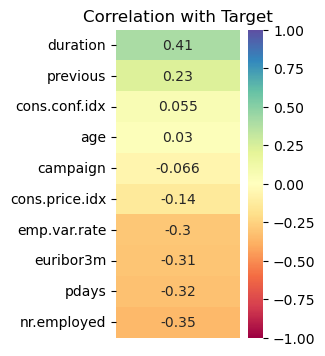

In [55]:
plt.figure(figsize=(2, 4))
plt.title('Correlation with Target')
sns.heatmap(pd.DataFrame(corr_target_matrix).sort_values(by=0, ascending=False),
            vmin=-1,
            vmax=1,
            cmap='Spectral',
            center=0.,
            annot=True,
            xticklabels=False)
plt.show()

1. Strongest Positive Correlation:
- `duration` (0.41): This is the most strongly correlated feature with the target variable. Longer call durations likely indicate higher customer engagement, which increases the likelihood of a positive outcome. This feature shouldn't be using in modeling.
- `previous` (0.23): The number of previous contacts shows a moderate positive correlation, suggesting that customers contacted multiple times in the past are more likely to respond positively.
2. Strongest Negative Correlation:
- `nr.employed` (-0.35), `euribor3m` (-0.31), and `emp.var.rate` (-0.30): These economic indicators have a negative correlation with the target variable, implying that a stronger economy (higher employment and interest rates) might reduce the likelihood of a successful outcome.
- `pdays` (-0.32): The number of days since the client was last contacted also shows a negative correlation, meaning recent contacts may be more effective.
3. Weak or Insignificant Correlation:
- `age` (0.03), `cons.conf.idx` (0.05): These variables have very weak correlations with the target, meaning they may not be strong predictors on their own.
- `campaign` (-0.07): A slightly negative correlation suggests that too many contact attempts may reduce effectiveness.

**Conclusions:**
- `duration` is the strongest predictor, but it also introduce leakage, as call duration is only known after the contact is made.
- Economic indicators (`nr.employed`, `euribor3m`, `emp.var.rate`) have a notable impact, suggesting that the overall economic climate influences the outcome.
- High `pdays` values indicate a lower likelihood of a positive response, which could inform future contact strategies.
- Weakly correlated features like `age`, `campaign` and `cons.conf.idx` might need further feature engineering or interaction effects to become useful.

### Multivariate analysis with target

In [56]:
def bi_boxplot(data, cat_column, continuous_column, hue_column):
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data,
                x=cat_column,
                y=continuous_column,
                hue=hue_column)
    plt.show()

#### `previous` vs. `pdays`

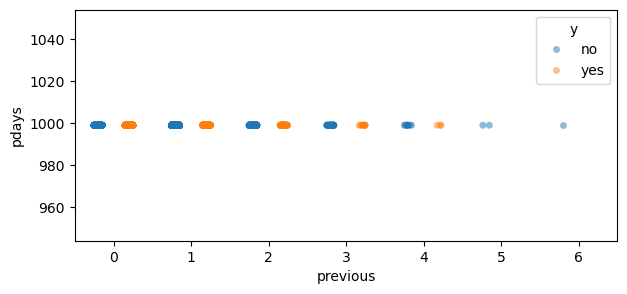

In [57]:
plt.figure(figsize=(7, 3))
sns.stripplot(data[data['pdays'] == 999],
              x='previous',
              y='pdays',
              hue='y',
              dodge=True,
              alpha=.5)
plt.show()

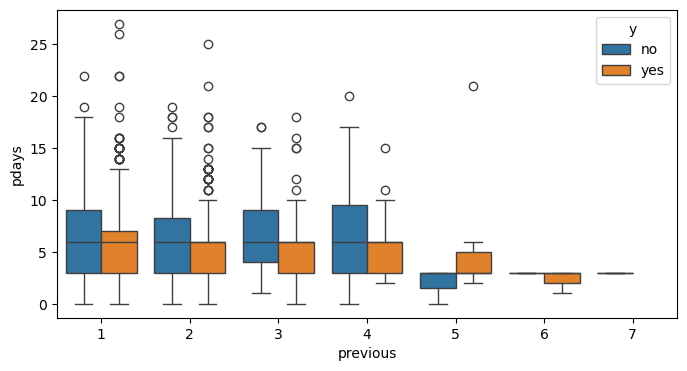

In [58]:
bi_boxplot(data[data['pdays'] != 999], 'previous', 'pdays', 'y')

- For clients with 1, 2, 3, 4 or 6 previous contacts, the likelihood of not subscribing increased as `pdays` values increased.
- In contrast, for clients with 5 previous contacts, the likelihood of subscribing increased when `pdays` values were higher.

#### `previous` vs. `nr.employed`

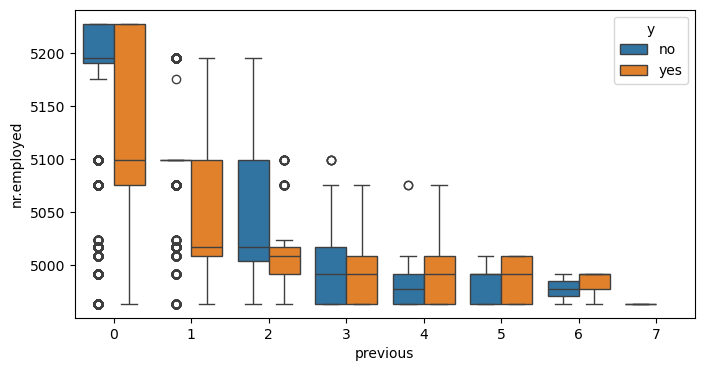

In [59]:
bi_boxplot(data, 'previous', 'nr.employed', 'y')

- Clients who had no prior contacts before this campaign were more likely to subscribe to a term deposit, regardless of the `nr.employed` value (median around 5100). In contrast, those who did not subscribe tdo it when `nr.employed` typically had values around 5200.
- For clients with 1 or 2 previous contacts, the likelihood of subscribing increased when `nr.employed` values were lower.

#### `previous` vs. `euribor3m`

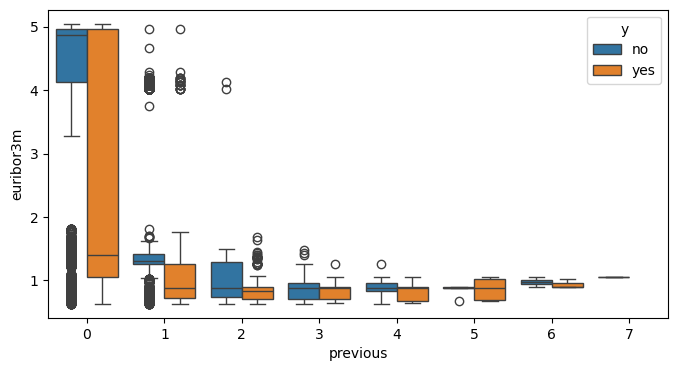

In [60]:
bi_boxplot(data, 'previous', 'euribor3m', 'y')

- The relationship between `previous` and `euribo3m` is very similar to the relationship between `previous` and `nr.employed`.
- Clients who had no prior contacts before this campaign were more likely to subscribe to a term deposit, regardless of the `euribo3m` value (with a median about 1.3). In contrast, those who did not subscribe do it when `euribo3m` values typically ranging from 4 to 5, with a median close to 5.
- For clients with 1, 2, 3, 4, or 6 previous contacts, likelihood of subscribing increased when `euribo3m` values were lower. 

#### `previous` vs. `emp.var.rate`

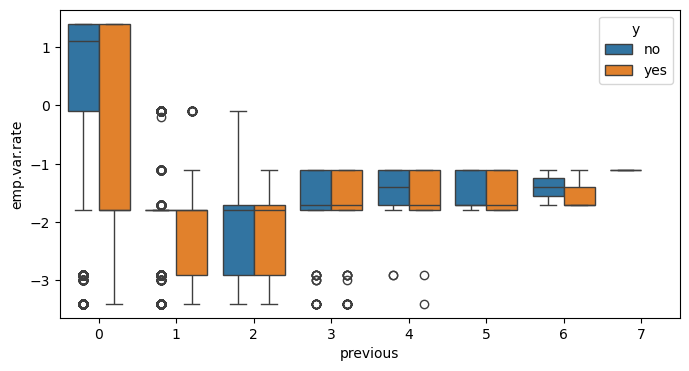

In [61]:
bi_boxplot(data, 'previous', 'emp.var.rate', 'y')

- The behavior of clients with 2, 3, 4, or 5 prior contacts don't dependent  of the `emp.var.rate` values.
- Clients who had no prior contacts before this campaign were more likely to subscribe to a term deposit, regardless of the `emp.var.rate` value. In contrast, those who did not subscribe did it when `emp.var.rate` values typically ranging from 0 to 1.4, with a median close to 1.1.

### Outliers

#### Outliers in numerical variables

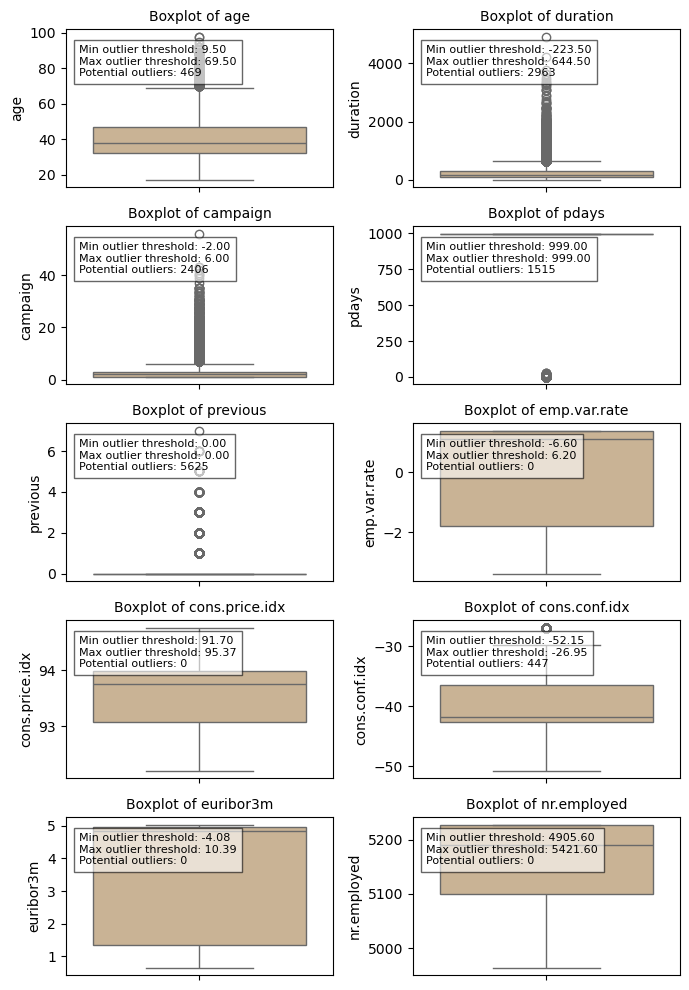

In [62]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    min_value, max_value, num_outliers = outlier_range(data, col)

    sns.boxplot(y=data[col], ax=axes[i], color='tan')
    axes[i].set_title(f"Boxplot of {col}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel(col)

    # Add text with outlier information
    text = (f"Min outlier threshold: {min_value:.2f}\n"
            f"Max outlier threshold: {max_value:.2f}\n"
            f"Potential outliers: {num_outliers}")

    axes[i].text(0.05, 0.9, text, transform=axes[i].transAxes,
                 fontsize=8,
                 verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

`pdays = 999` means that the client was not previously contacted. Let's plot the distribution of `pdays` for clients, which have contacts.

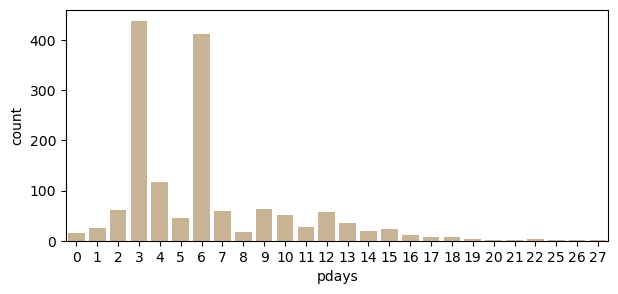

In [63]:
plt.figure(figsize=(7, 3))
sns.countplot(x=data.loc[data['pdays'] != 999, 'pdays'], color='tan')
plt.show()

- Features such as `duration`, `campaign`, `pdays`, and `previous` show significant outliers beyond the interquartile range (IQR), indicating extreme values that may impact model performance.
- `duration`: Contains high-value outliers, suggesting that a few customers had exceptionally long call durations. These could represent successful marketing interactions but also indicate data leakage, as longer calls correlate directly with a positive outcome.
- `campaign`: The presence of outliers suggests that some customers received an unusually high number of calls, which may indicate diminishing returns on repeated contact attempts.
- `pdays`: Exhibits extreme values, suggesting that some clients were contacted after a very long gap, but in reality, they were not previously contacted. High values in this feature could be replace with -1 for better clarity and interpretation.
- `previous`: Outliers suggest that certain customers had been contacted numerous times before, which could impact their likelihood of responding.

**Handling Strategy for Outliers**
- Investigate outliers further to determine if they are genuine or due to errors.
- Log transformation or scaling techniques may help reduce the impact of skewed distributions.
- Further domain-specific understanding is needed to decide whether to keep or remove these outliers.

### Duplicates

In [64]:
print(f"{data.duplicated().sum()} rows have duplicate")

12 rows have duplicate


In [65]:
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cons.price.idx_diff,cons.conf.idx_diff
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,"5,228.10",no,-0.55,-0.90
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,"5,228.10",no,-0.55,-0.90
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,"5,228.10",no,-0.55,-0.90
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,"5,228.10",no,-0.55,-0.90
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,"5,228.10",no,-0.55,-0.90
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,"5,228.10",no,-0.55,-0.90
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,"5,228.10",no,-0.55,-0.90
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,"5,228.10",no,-0.55,-0.90


The duplicate rows are actually duplicates so we could remove them. 

In [66]:
data = data.drop_duplicates()

In [67]:
print(f"Shape after dropping duplicates: {data.shape}")

Shape after dropping duplicates: (41176, 23)


## Save the data

In [68]:
data.to_csv('./data/bank_data.csv', index=False)

### Conclusion: Categories of Clients to Target with a Term Deposit Offer

**Client Characteristics:**
- Clients with prior contacts.
- Clients in job categories such as `admin.`, `retired`, and `student`.
- `Single` clients.
- Clients with `university degree`.
- Clients without existing credits.
- Clients using the `cellular` communication type.
- Clients with `success` result in the previous marketing campaign.

**Favorable Conditions for Offer:**
- When 3 or 6 days have passed since the last contact from a previous campaign.
- When the `employment variation rate` is below -0.1.
- When `euribor3m` is below 2.
- When the number of employees is lower (less than 5100).
- During April, October, September, March, and December (but not in May).